# DATASCI W261: Machine Learning at Scale

## HW11

- **Juanjo Carin**
- [juanjose.carin@ischool.berkeley.edu](mailto:juanjose.carin@ischol.berkeley.com)
- W261-2
- Week 11
- Submission date: 11/24/2015

## Spark initialization

In [1]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = \
   '/HD/spark/'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.2
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:04:42)
SparkContext available as sc, HiveContext available as sqlContext.


# HW11.0: Broadcast versus Caching in Spark

## HW11.0.1
**What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.**

When we **broadcast** a variable we send it to all the worker nodes. This is specially suited for a large, read-only variable, which is cached on each machine rather than shipped (a copy of it) with tasks, and is useful mainly when tasks across multiple stages need the same data...and these data change over time (with each new iteration). **Caching** data, on the other hand, is inefficient when those data are used in multiple parallel operations, because data are sent many times unnecessarily.

In **Machine Learning** algorithms there are some data are fixed (e.g., the training data) and hence are suitable to be cached (besides, each executor may handle only part of those training data); but others, like feature vectors, weights, centroids, and so on, change after each iteration and are needed (as a whole) by each executor.

For example, the code below (for Linear Regression based on Gradient Descent) is inefficient (especially if the data has multiple dimensions, and hence the weight vector is very long), because if the weight vector has to be splitted in N chunks, we have to ship (serialize) this vector to each of the M executors N times:

```python
def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    else:
        w = wInitial
    for i in range(iterations):
        gradient = data.\
            map(lambda d: -2 * (d[0] - np.dot(w, d[1:])) * np.array(d[1:])).\
            reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w
```

If we broadcast the weight vector, the data has to be sent only M times:

```python
def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    else:
        w = wInitial
    for i in range(iterations):
        ## Make available in memory as read-only to the executors
            ## (for Spark operations: transformations & actions)
        wBroadcast = sc.broadcast(w)  
        gradient = data.map(lambda d: -2 * (d[0] - 
            np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])).\
            reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w
```

## HW11.0.2
**Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:**

**https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0**

First we generate the same data (no changes with respect with original code):

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

We use 2 functions:

1. One to get the cluster centroid closer to any point in the dataset. It calls the `value` on the broadcast variable `centroidsBroadcast`, as its argument is each of the datapoints.

2. An optional function to plot the current centroids. Its argument will be the broadcast centroids, so there's no need to explicitly mention them.

In [3]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    #### USE BROADCAST VALUES
    closest_centroid_idx = np.sum((x - centroidsBroadcast.value)**2, axis=1).\
        argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    plt.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    plt.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    plt.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    plt.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    plt.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    plt.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    plt.show()

The driver makes use of both functions above. It first creates K random centroids...that are broadcasted to all executors (probably just 1 in this toy example), and then updates (**broadcasts**) this broadcast variable in each iteration, as the datapoints closer to each centroid change.

Iteration0
[[ 0.92842153  0.44406917]
 [ 3.87888277  2.65594657]
 [ 2.23840634  5.79508998]]


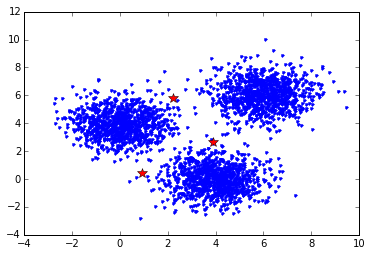

Iteration1
[[ 1.50086233  1.10070232]
 [ 5.07806843  2.17728244]
 [ 2.79206515  5.53294056]]


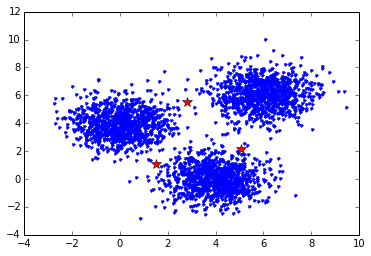

Iteration2
[[ 1.26409076  1.66994805]
 [ 5.22473443  1.64466205]
 [ 3.52152631  5.72850242]]


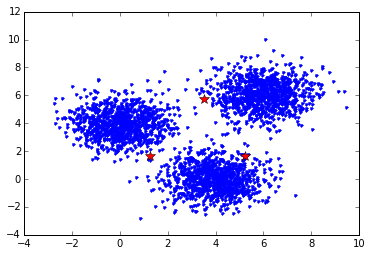

Iteration3
[[ 0.49086437  2.86795731]
 [ 4.51911824  0.3103002 ]
 [ 5.08016944  6.03098872]]


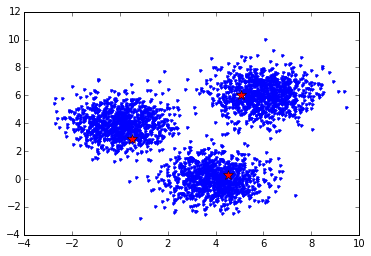

Iteration4
[[  4.67817517e-02   3.91308552e+00]
 [  3.99980366e+00   3.65913994e-03]
 [  5.94147255e+00   6.07037913e+00]]


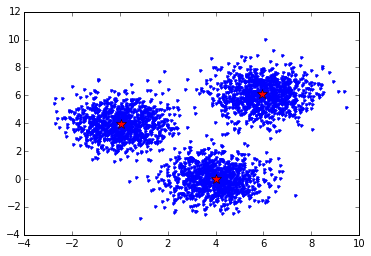

Iteration5
[[ 0.02419829  3.98731347]
 [ 3.95666525  0.02669353]
 [ 5.97538395  6.06835998]]


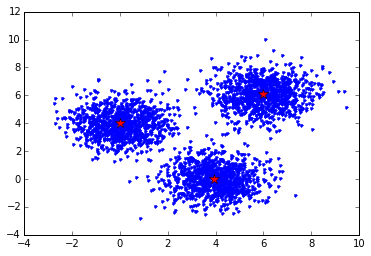

Final Results:
[[ 0.02419829  3.98731347]
 [ 3.95666525  0.02669353]
 [ 5.97538395  6.06835998]]


In [4]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])
#### BROADCAST INITIAL CENTROIDS
centroidsBroadcast = sc.broadcast(centroids)

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).\
        reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])
        #divide by cluster size
    #### USE BROADCAST VALUE TO CHECK CONDITION
    if np.sum(np.absolute(centroids_new-centroidsBroadcast.value))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    #### UPDATE CENTROIDS AND BROADCAST
    centroidsBroadcast = sc.broadcast(centroids_new)
    #### PRINT NEW CENTROIDS
    print centroidsBroadcast.value
    #### PLOT NEW CENTROIDS
    plot_iteration(centroidsBroadcast.value)
print "Final Results:"
print centroidsBroadcast.value

# HW11.1: Loss Functions

## HW11.1.1
**In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regresssion learning algorithm?**

**In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.**

Not necessarily, though if we let both algorithms converge the results (the hyperplanes, and hence the predictions) should be quite similar.

The separatign surface in both algorithms is an hyperplane (specified by an equation of the type $w^T x$, though in the case of the Logistic Regression it represents the logit of the likelihood, i.e., hte logarithm of the Odds Ratio), but the SVM does not intend to minimize any loss function (as the Logistic Regression does), but only the regularization term (similar to the L2 regularization term in the Logistic Regression; in the case of a SVM, the regularization term would be inversely proportional to the margin.

To demonstrate this, **see the addendum at the end of HW11.3.3**.

## HW11.1.2
**In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm?**

Same answer as before: the final result (the weights, and hence the decision boundary or hyperplane that makes datapoints to fall into one category or the other) will be similar but not necessarily equal.

# HW11.2: Gradient descent

## HW11.2.1
**In the context of logistic regression describe and define three flavors of penalized loss functions. Are these all supported in Spark MLLib (include online references to support your answers)?**

In Logistic Regression the objective function (or penalized loss function) we want to minimize is defined as:

$$J(w)=\sum_iL(\mathbf{w},\mathbf{x_i},y_i)+\lambda R(\mathbf{w}) = \sum_i log(1+e^{-y \mathbf{w}^T \mathbf{x}_i})+\lambda R(\mathbf{w})$$

where $y \in \{-1,+1\}$ (the definition of the loss term $L(\mathbf{w},\mathbf{x_i},y_i)$ is different when $y \in \{0,+1\}$).

Three flavors of the regularization term would be:
1. **Lasso**, where the L1 norm lf $w$ is used (as $R(\mathbf{w})$: $\left \|  \mathbf{w}\right \|_1$
    - It can help promote sparsity in weights leading to smaller and more interpretable models, the latter of which can be useful for feature selection. 
2. **Ridge**, where the L2 norm of $w$ is used: $\frac{1}{2}\left \|  \mathbf{w}\right \|_2^2$
    - Generally easier to solve than L1-regularized due to smoothness.
3. **Elastic net**, a (weighted) combination of the previous two ones: $\alpha \left \|  w\right \|_1 + (1-\alpha)\frac{1}{2}\left \|  w\right \|_2^2$

All of them are supported in Spark MLLib: http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions

## HW11.2.2
**Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression.**

To make it simple, I will use the case in which there are only 2 features or independent variables.

In Logistic Regression we want to maximize the likelihood of a class given the independent variables: $\Pr(y=+1 \mid \mathbf{x})$. The loss term is the inverse of (the logit of) that prior, and hence we want to minimize it. That loss term is a function of $w_1$ and $w_2$ and thus defined in $\mathbb{R}^2$.

The L1 regularization term adds a constraint in finding the minimum of $L(\mathbf{w},\mathbf{x},y)$: $|w_1| + |w_2|$ cannot exceed a certain value (i.e., $(w_1, w_2)$ is inside a "diamond". That's like adding a prior to the weights: instead of minimizing the cost function (i.e., maximizing the likelihood) given the training data, we are maximizing the likelihood given the *additional information bias*.

The same applies to the L2 regularization term, but in this case the constraint puts $(w_1,w_2)$ inside a circle ($|w_1|^2+|w_2|^2$ cannot exceed a certain value).

-----

L1 and L2 are also called Laplacian and Gaussian priors, respectively. The Laplacian pdf is similar to the Gaussian but it uses the L1 norm (or Manhattan distance) rather than the L2 norm (or Euclidean distance).

# HW11.3: Logistic Regression

## HW11.3.1
**Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.**

Each data set will have 100 points, 50 in each category.

In [5]:
def generateData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    from numpy.random import rand ## Seems like this line was missing    
    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

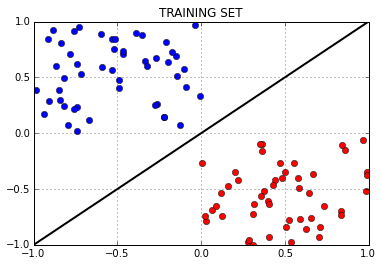

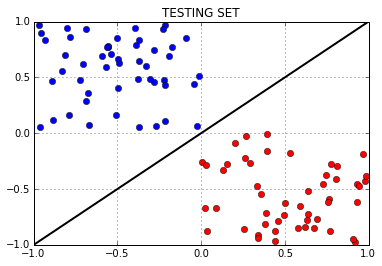

In [6]:
for i in range(2):
    data = generateData(50)
    data = np.array([np.array(xi) for xi in data])
    plt.plot(data[data[:,2]==1, 0], data[data[:,2]==1, 1], 
               'o', color = 'blue')
    plt.plot(data[data[:,2]==-1, 0], data[data[:,2]==-1, 1], 
               'o', color = 'red')
    if i == 0:
        training_set = data
        plt.title('TRAINING SET')
    else:
        testing_set = data
        plt.title('TESTING SET')
    plt.plot([-1,1], [-1,1], linewidth=2.0, color = 'black')
    plt.grid()
    plt.show()

## HW11.3.2
**Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets.**

Of the 100 points in each dataset, approximately (well, exactly in this case) 10% (5 in the $x>0, y<0$ region and 5 in the $x<0, y>0$ region) will be assigned the wrong label.

Those points can be anywhere in the wrong region (I was not sure if they should be more likely near the origin (and hence the separating hyperplane).

In [7]:
def generateData2(n):
    """ 
    generates a 2D NON-linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    from numpy.random import rand ## Seems like this line was missing    
    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    inputs = []
    wrong = 0.1
    for i in range(int(round(len(xb)*wrong))):
        ## FIRST 10% OF THE GENERATED POINTS ARE ASSIGNED THE WRONG LABEL
        inputs.append([xb[i],yb[i],-1])
        inputs.append([xr[i],yr[i],1])
    for i in range(int(round(len(xb)*wrong)), len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    #inputs = np.array([np.array(xi) for xi in inputs])
    #np.random.shuffle(inputs)
    return inputs

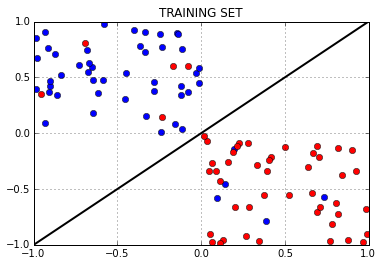

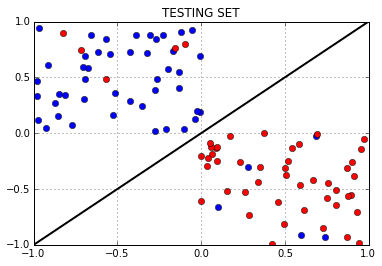

In [8]:
import csv

for i in range(2):
    data = generateData2(50)
    data = np.array([np.array(xi) for xi in data])
    plt.plot(data[data[:,2]==1, 0], data[data[:,2]==1, 1], 
               'o', color = 'blue')
    plt.plot(data[data[:,2]==-1, 0], data[data[:,2]==-1, 1], 
               'o', color = 'red')
    if i == 0:
        training_set = data
        with open('training_set.csv', 'wb') as f:
            writer = csv.writer(f)
            for row in data:
                writer.writerow(row)
        plt.title('TRAINING SET')
    else:
        testing_set = data
        with open('testing_set.csv', 'wb') as f:
            writer = csv.writer(f)
            for row in data:
                writer.writerow(row)
        plt.title('TESTING SET')
    plt.plot([-1,1], [-1,1], linewidth=2.0, color = 'black')
    plt.grid()
    plt.show()

**NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.**

## HW11.3.3
**Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words.**

SOME COMMENTS ABOUT THE CONVERGENCE CRITERIA (that I've chosen):

Let's assume that at a certain iteration, we have the following hyperplane equation: $\pi_1: w_1 x_1 + w_2 x_2 + w_3 = 0$.

For another hyperplane, $\pi_2: w_3 x_1 + w_4 x_2 + w_5 = 0$ (say the one in the following iteration), to be the same, the following condition must be met:

$$\exists \gamma  / \gamma \pi_2 = \pi_1$$

I.e.,

$$\left\{\begin{matrix}
\gamma = \frac{w_1}{w_4}\\ 
\gamma = \frac{w_2}{w_5}\\ 
\gamma = \frac{w_4}{w_6}
\end{matrix}\right.$$

I.e, we don't care if a weight doubles from one iteration to the next, as long as the same happens with all the weights.

To relax the condition, I'll consider that 2 hyperplanes are (almost) the same if the 3 relations above are very similar, i.e.

$$\frac{w_1}{w_4} \simeq \frac{w_2}{w_5} \simeq \frac{w_3}{w_6}$$

Let's say that 2 numbers are similar if their ratio is lower than 1.01 or higher than 0.99 (they have increased or decreased 1% at max), i.e.,

$$\frac{\frac{w_i}{w_{i+3}}}{\frac{w_j}{w_{j+3}}} \in [0.99,1.01]$$

for all possible combinations of $i,j \in \{1,N\}$, where $N$ is the number of features plus 1.

This criterion is a bit arbitrary, and it does not ensure that we have achieved the lowest misclassification error possible. But it can be made more strict just by changing that 1% by say 0.1% (that would be the way to go, rather than imposing any criterion about the misclassification error, which we would not know in a real case).

In [9]:
#### EXAMPLE
prev_w = np.arange(1,4)
print 'Previous w:\t\t\t', prev_w
w = prev_w * (2 + np.random.normal(size=3)/100)
print 'New w:\t\t\t\t', w
ratio = w/prev_w
print 'Gammas:\t\t\t\t', ratio
## We have to compare all possible ratios: 1 with 2, 1 with 3, 2 with 3
import itertools
comb = [x for x in itertools.combinations(range(len(w)),2)]
ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) for (i,j) in comb])
print 'Ratios of gammas:\t\t', ratio_of_ratio
condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
print 'Check condition of ratios:\t', condition
print 'Check overall condition:\t', condition.all(axis=0)

Previous w:			[1 2 3]
New w:				[ 2.00438958  4.00398063  5.98749635]
Gammas:				[ 2.00438958  2.00199031  1.99583212]
Ratios of gammas:		[ 1.00119844  1.00428767  1.00308553]
Check condition of ratios:	[ True  True  True]
Check overall condition:	True


Iteration: 0
(weights=[0.0,0.0], intercept=1.0)
Testing Error: 0.5
------------------
Iteration: 1
(weights=[-1.10715600206,1.07165780808], intercept=0.55211938224196)
Testing Error: 0.22
------------------
Iteration: 2
(weights=[-1.68076894691,1.60242352252], intercept=0.1321699080343927)
Testing Error: 0.1
------------------
Iteration: 3
(weights=[-1.96710376601,1.82319317225], intercept=-0.08211588507449635)
Testing Error: 0.1
------------------
Iteration: 4
(weights=[-2.12509666494,1.92155683104], intercept=-0.06161617885913849)
Testing Error: 0.1
------------------
Iteration: 5
(weights=[-2.22938927355,1.92924977614], intercept=-0.039179750528536686)
Testing Error: 0.1
------------------
Iteration: 6
(weights=[-2.30601343045,1.88818510939], intercept=-0.023674869031762663)
Testing Error: 0.1
------------------
Iteration: 7
(weights=[-2.38781765969,1.80556805606], intercept=-0.016014399544537528)
Testing Error: 0.1
------------------
Iteration: 8
(weights=[-2.40051383568,1.77983665

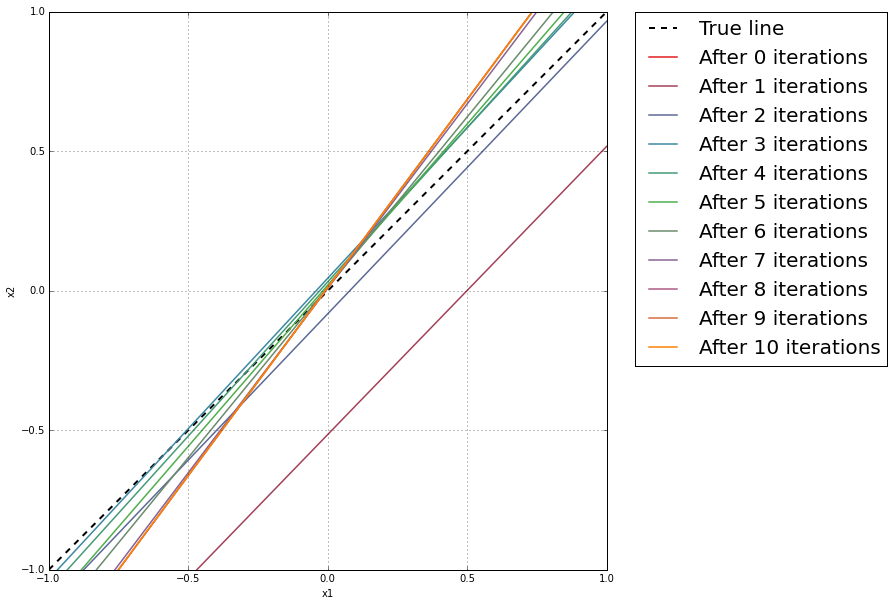

In [10]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, \
    LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
import itertools

iterations = 20
## Define equally spaced colors for each iteration
colors = plt.cm.Set1(np.linspace(0, 1, iterations+1))

def parsePoint(line):
    ## Change labels to 0 and 1 (rather than -1 and 1)
        ## Those are the values accepted by MLLib
    values = [float(x) for x in line.split(',')]
    if values[2] == -1:
        y = 0
    elif values[2] == 1:
        y = 1
    return LabeledPoint(y, values[:2])

## Load and cache both sets
training = sc.textFile("training_set.csv")
testing = sc.textFile("testing_set.csv")
training = training.map(parsePoint).cache()
testing = testing.map(parsePoint).cache()

## Draw the true hyperplane
x1 = [-1, 1]
w = [-1, 1, 0]
x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
plt.figure(figsize=(10,10))
plt.plot(x1, x2, 'b', label="True line", linewidth=2.0, color = 'black', 
         linestyle='--')

prev_w = [float('inf')]*3
#prev_Err = float('inf')

## Try a few iterations (no need for more in this case)
for it in range(iterations+1):
    print 'Iteration: {}'.format(it)
    # Build the model (Lasso/L1, lambda = 0.5)
    model = LogisticRegressionWithLBFGS.train(training, regType="l1", 
                                              regParam=0.01, 
                                              intercept = True, 
                                              iterations = it)
    print model

    # Evaluating the model on testing data
    labelsAndPreds = testing.\
        map(lambda p: (p.label, model.predict(p.features)))
    Err = labelsAndPreds.\
        filter(lambda (v, p): v != p).count() / float(testing.count())
    w = [model.weights[0], model.weights[1], model.intercept]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    ## Plot the hyperplanes
    plt.plot(x1, x2, color=colors[it], label="After {} iterations".
             format(str(it)), linewidth=1.5)
    
    ## Stop when it converges
    ## Convergence is decided based on the relative change of the weights
        ## An absolute change makes no sense since we don't know a priori
            ## how large the weights will be
        ## The criteria I've chosed is than, on average, the weight vector
            ## has converged when each weight, on average is less than 33%
            ## above/below its previous value
    #if sum([abs(float(a)/b) if abs(float(a)/b) > 1 else abs(float(b)/a) 
    #        for (a,b) in zip(w,prev_w)]) < len(w)+1 \
    #    and trainErr == prev_trainErr:
        ## NEW CRITERIA: None the weights (incl. the intercept) is 25%
            ## above/below its previous value
    #if max([abs(float(a)/b) if abs(float(a)/b) > 1 else abs(float(b)/a) 
    #        for (a,b) in zip(w,prev_w)]) < 1.25 and trainErr == prev_trainErr:
    #    break
    
    comb = [c for c in itertools.combinations(range(len(w)),2)]
    ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) 
                               for (i,j) in comb])
    condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
    if condition.all(axis=0):
        break
    
    prev_w = w
    #prev_Err = Err
    print "Testing Error: {}".format(str(Err))
    print '------------------'

## Last iteration's results
print "Testing Error: {}".format(str(Err))
print '------------------'
print 'CONVERGENCE AFTER {} ITERATIONS'.format(it)
print 'Relative change of weights (incl. intercept) between iterations '\
    '{} and {}:\n\t{}'.format(it-1, it, [a/b for (a,b) in zip(w,prev_w)])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
plt.grid()
plt.show()

The weight vector is relatively close to its final value just after the 2nd iteration. And at that point we've already achieved the lowest testing error possible (10%). The convergence criteria is met after 10 iterations.

Do note that the values of the weights (and the results commented above) are highly dependent on the value of `regParam` ($\lambda$; I used $\lambda = 0.01$).

### Additional
Comparison between Logistic Regression and SVM (using Ridge instead of Lasso).

In [11]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel

for i in range(10):
    print 'Iteration: {}'.format(i)
    # Build the model
    model_LR = LogisticRegressionWithLBFGS.train(training, regType="l2", 
                                                 regParam=0.01, 
                                                 intercept = True, 
                                                 iterations = i)
    
    model_SVM = SVMWithSGD.train(training, regType="l2", regParam=0.01, 
                                 intercept = True, iterations = i)
    print 'LogReg:\t{}'.format(model_LR)
    print 'SVM:\t{}'.format(model_SVM)

    # Evaluating the model on training data
    labelsAndPreds_LR = testing.\
        map(lambda p: (p.label, model_LR.predict(p.features)))
    labelsAndPreds_SVM = testing.\
        map(lambda p: (p.label, model_SVM.predict(p.features)))
    trainErr_LR = labelsAndPreds_LR.\
        filter(lambda (v, p): v != p).count() / float(testing.count())
    trainErr_SVM = labelsAndPreds_SVM.\
        filter(lambda (v, p): v != p).count() / float(testing.count())
    print "Testing Error:"
    print "\tLR:\t{}".format(str(trainErr_LR))
    print "\tSVM:\t{}".format(str(trainErr_SVM))
    print '-------------------'

Iteration: 0
LogReg:	(weights=[0.0,0.0], intercept=1.0)
SVM:	(weights=[0.0,0.0], intercept=1.0)
Testing Error:
	LR:	0.5
	SVM:	0.5
-------------------
Iteration: 1
LogReg:	(weights=[-1.10715600206,1.07165780808], intercept=0.55211938224196)
SVM:	(weights=[-0.189765064992,0.19328077111], intercept=0.49)
Testing Error:
	LR:	0.22
	SVM:	0.5
-------------------
Iteration: 2
LogReg:	(weights=[-1.70279250757,1.623554186], intercept=0.15240424166872313)
SVM:	(weights=[-0.470588018506,0.482956054954], intercept=0.4865351767721859)
Testing Error:
	LR:	0.1
	SVM:	0.31
-------------------
Iteration: 3
LogReg:	(weights=[-1.96789695187,1.82721197145], intercept=-0.020960095730284206)
SVM:	(weights=[-0.605507124377,0.633900753184], intercept=0.35670910539767176)
Testing Error:
	LR:	0.1
	SVM:	0.22
-------------------
Iteration: 4
LogReg:	(weights=[-2.13041431516,1.90977384096], intercept=-0.09211416237110645)
SVM:	(weights=[-0.715648172666,0.748921153708], intercept=0.2249255598706834)
Testing Error:
	L

The testing error is highly dependent on the value of $\lambda$, especially in the case of the SVM (which seems to converge also more slowly).

Though not plotted here, the final hyperplanes are quite similar: $w_0 \simeq  0, w_1 \simeq -w2$, so the lines are both diagonals almost crossing the origin.

## HW11.3.4

**Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm.**

The following function is general purpose: we just have to weight each point before passing it to the function as an argument. So I start analyzing the results of the unweighted version.

The convergence test is the same as before.

The function already checks the misclassification error, but for the moment we'll test the training set.

In [12]:
def logRegressionGDReg(training, testing, wInitial=None, learningRate=0.05, 
                       iterations=50, regParam=0.01, regType=None):

    ## Draw the true hyperplane
    x1 = [-1, 1]
    w = [-1, 1, 0]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.figure(figsize=(10,10))
    plt.plot(x1, x2, 'b', label="True line", linewidth=2.0, color = 'black', 
             linestyle='--')

    featureLen = len(training.take(1)[0].x)
    n = training.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
        #w = [0]*featureLen
        #w[-1] = 1
        #w = np.array(w)
    else:
        w = wInitial
    prev_w = np.array([float('inf')]*featureLen)
    #prev_Err = float('inf')
    Err_vector = []
    convergence = False
    
    x1 = [-1,1]
    colors = plt.cm.Set1(np.linspace(0, 1, iterations/25+1))
    
    for it in range(iterations+1):
        wBroadcast = sc.broadcast(w)
        gradient = training.\
            map(lambda p: (1 / (1 + np.exp(-p.y * np.dot(wBroadcast.value, 
                                                         p.x)))-1) * p.y * 
                np.array(p.x)).\
            reduce(lambda a, b: a + b)
        errors = testing.\
            map(lambda p: p.y != (np.dot(wBroadcast.value, p.x)>0).
                astype(int)*2 - 1).\
            filter(lambda wx: wx == True).count()
        Err = float(errors) / n
        Err_vector.append(Err)
        
        if Err == 0.1 and convergence == False:
            print '+++++++++++++++++++++++++++++++++++++++'
            print 'Minimum error achieved at iteration {}'.format(it)
            print 'Ratio of weights at this iteration:'
            print '\t{}'.format(ratio_of_ratio)
            print '+++++++++++++++++++++++++++++++++++++++'
            convergence = True

        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg
        ## Gradient: GD of Squared Error+ GD of regularized term 
        w = w - learningRate * gradient / n
        if it % 25 == 0 and it != 0:
            print 'Iteration {}'.format(str(it))
            print '\tWeights:\t{}'.format(w)
            print '\tError rate:\t{}'.format(str(Err))
            print '----------------------------'
            x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
            ## Plot the hyperplanes
            plt.plot(x1, x2, color=colors[it/25], label="After {} iterations".
                 format(str(it)), linewidth=1.5)
        
        ## STOP IF CONVERGENCE
        comb = [c for c in itertools.combinations(range(len(w)),2)]
        ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) 
                                   for (i,j) in comb])
        condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
        if condition.all(axis=0):
            if Err != 0.1:
                if convergence == False:
                    print '+++++++++++++++++++++++++++++++++++++++++++'
                    print 'Converge criterion met after {} iterations'\
                        '\nbut lowest error not achieved yet.'.format(str(it))
                    print '+++++++++++++++++++++++++++++++++++++++++++'
                    convergence = True
            else:
                print 'Converged after {} iterations.'.format(str(it))
                print '\tWeights:\t{}'.format(w)
                print '\tError rate:\t{}'.format(str(Err))
                x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
                plt.plot(x1, x2, color='red', label="After {} iterations".
                         format(str(it)), linewidth=2.0)
                plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, 
                           borderaxespad=0.)
                plt.xlabel("x1")
                plt.ylabel("x2")
                axes = plt.gca()
                axes.set_xlim([-1,1])
                axes.set_ylim([-1,1])
                plt.grid()
                plt.show()
                break
        prev_w = w
        #prev_Err = Err
        if it == iterations:
            print 'Not enough iterations to converge'
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, 
                       borderaxespad=0.)
            plt.xlabel("x1")
            plt.ylabel("x2")
            axes = plt.gca()
            axes.set_xlim([-1,1])
            axes.set_ylim([-1,1])
            plt.grid()
            plt.show()
    return Err_vector

Iteration 25
	Weights:	[-0.39357784  0.66779852 -0.38830049]
	Error rate:	0.21
----------------------------
Iteration 50
	Weights:	[-0.5463173   0.81944238 -0.30016639]
	Error rate:	0.13
----------------------------
Iteration 75
	Weights:	[-0.67692822  0.94813931 -0.23803656]
	Error rate:	0.13
----------------------------
Iteration 100
	Weights:	[-0.79014562  1.05878545 -0.19398006]
	Error rate:	0.11
----------------------------
Iteration 125
	Weights:	[-0.88950344  1.15503228 -0.16254045]
	Error rate:	0.11
----------------------------
+++++++++++++++++++++++++++++++++++++++++++
Converge criterion met after 136 iterations
but lowest error not achieved yet.
+++++++++++++++++++++++++++++++++++++++++++
Converged after 140 iterations.
	Weights:	[-0.94358905  1.20703057 -0.1481318 ]
	Error rate:	0.1


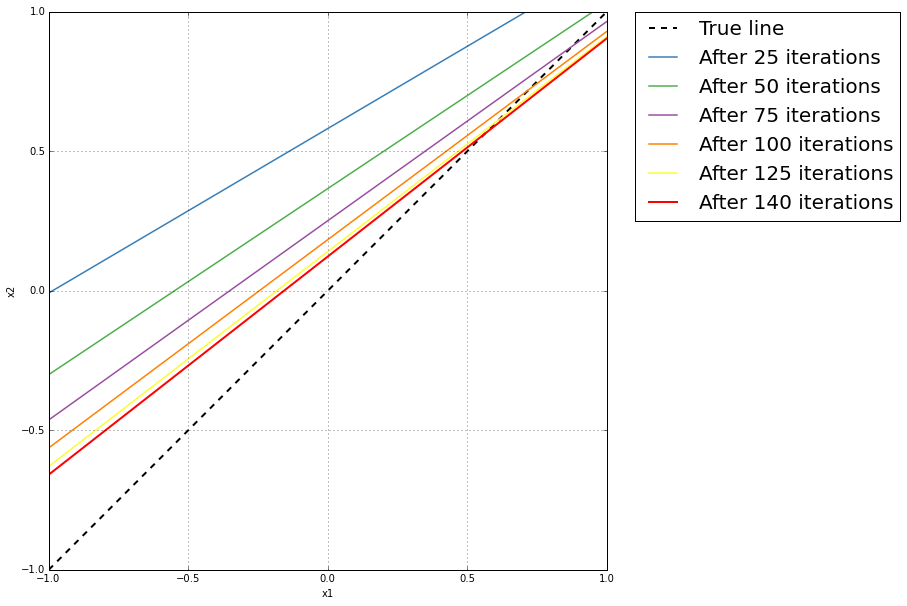

In [13]:
from collections import namedtuple
Point = namedtuple('Point', 'x y')

def readPoint(line):
    d = line.split(',')
    x = [float(i) for i in d[:2]]
    x.append(1.0)  #bias term
    return Point(x, float(d[2]))

train = sc.textFile('training_set.csv').map(readPoint).cache()

np.random.seed(12345)

Error_Vector_LR1 = logRegressionGDReg(train, train, iterations=200, 
                                      regParam=0.01, regType="Lasso")

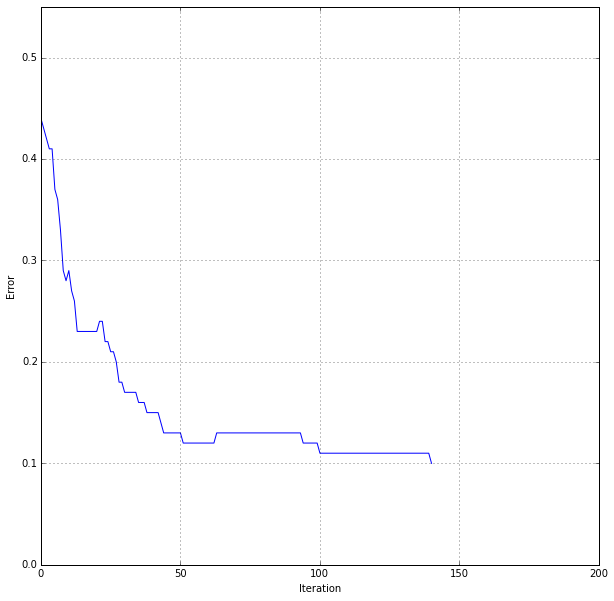

In [14]:
num_iter = len(Error_Vector_LR1)
plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_LR1)
plt.xlabel("Iteration")
plt.ylabel("Error")
axes = plt.gca()
#axes.set_ylim([np.floor(min(Error_Vector_LR1)*20)/20-.05, 
#               np.ceil(max(Error_Vector_LR1)*20)/20+.05])
#axes.set_xlim(0, num_iter)
axes.set_ylim(0,0.55)
axes.set_xlim(0,200)
plt.grid()
plt.show()

The unweighted version of the homegrown code has the lowest misclasiffication error at the 140th iteration (compared to the 2nd in the MLLib version), though it reaches convergence (based on the criterion previously described) before that, at the 136th iteration (compared to the 10th in the MLLib version).

The hyperplane is not exaclty the true one (but that's highly dependent on the random datase we generated).

## HW11.3.5
**Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm):**
        
    weight(X)= 1/||X||

**where**

    ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

**Here X is vector made up of X1 and X2.**

To weight the training dataset we just have to apply the weights before calling the function defined before.

+++++++++++++++++++++++++++++++++++++++
Minimum error achieved at iteration 21
Ratio of weights at this iteration:
	[ 1.00910336  1.03241294  1.0230993 ]
+++++++++++++++++++++++++++++++++++++++
Iteration 25
	Weights:	[-0.42945973  0.6956434  -0.38687286]
	Error rate:	0.1
----------------------------
Iteration 50
	Weights:	[-0.60083431  0.85629573 -0.29759406]
	Error rate:	0.1
----------------------------
Iteration 75
	Weights:	[-0.74004084  0.98293521 -0.23355665]
	Error rate:	0.1
----------------------------
Iteration 100
	Weights:	[-0.85534247  1.08447356 -0.18652776]
	Error rate:	0.1
----------------------------
Iteration 125
	Weights:	[-0.95250846  1.16708464 -0.15115306]
	Error rate:	0.1
----------------------------
Iteration 150
	Weights:	[-1.03560219  1.2350943  -0.12395568]
	Error rate:	0.1
----------------------------
Converged after 171 iterations.
	Weights:	[-1.09668834  1.2832325  -0.105725  ]
	Error rate:	0.1


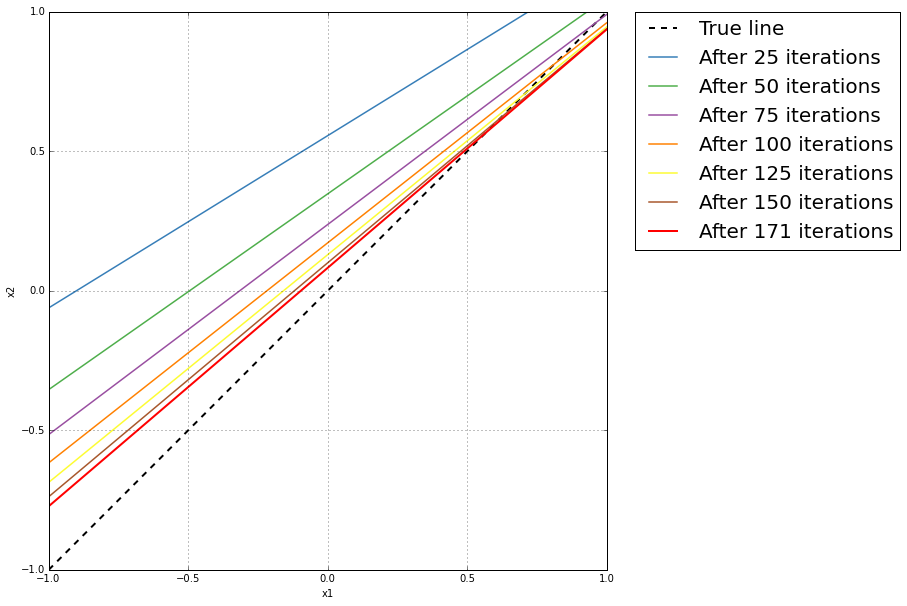

In [15]:
def readPoint_W(line):
    d = line.split(',')
    x = [float(i) for i in d[:2]]
    x = list(x/np.sqrt(np.sum(np.array(x)**2)))
    x.append(1.0)  #bias term
    return Point(x, float(d[2]))

train = sc.textFile('training_set.csv').map(readPoint_W).cache()

np.random.seed(12345)

Error_Vector_LR2 = logRegressionGDReg(train, train, 
                                      iterations=200, regParam=0.01, 
                                      regType="Lasso")

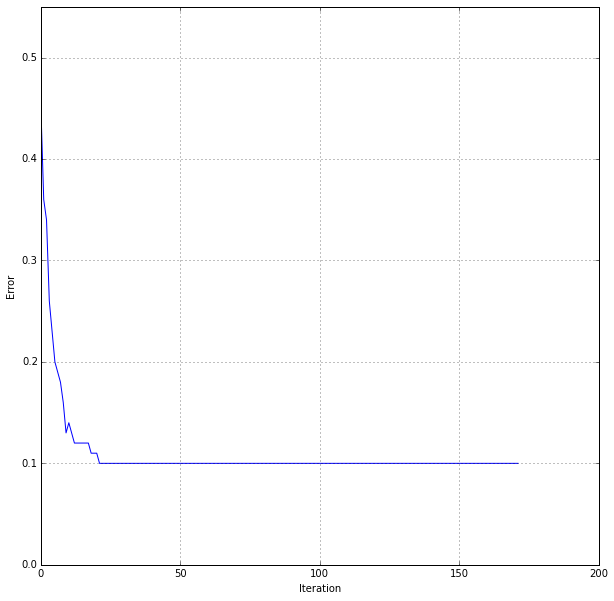

In [16]:
num_iter = len(Error_Vector_LR2)
plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_LR2)
plt.xlabel("Iteration")
plt.ylabel("Error")
axes = plt.gca()
axes.set_ylim(0,0.55)
axes.set_xlim(0,200)
plt.grid()
plt.show()

The weighted version converges at the 171st iteration (vs. 52nd in the unweighted version). And the minimum misclassification error (in the training set!) is achieved with quite less iterations: 21 instead of 140.

## HW11.3.6
**Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.**

Now we just have to use the testing set (instead of the training set) as the 2nd parameter.

+++++++++++++++++++++++++++++++++++++++
Minimum error achieved at iteration 20
Ratio of weights at this iteration:
	[ 1.00948478  1.0331094   1.02340266]
+++++++++++++++++++++++++++++++++++++++
Iteration 25
	Weights:	[-0.42945973  0.6956434  -0.38687286]
	Error rate:	0.1
----------------------------
Iteration 50
	Weights:	[-0.60083431  0.85629573 -0.29759406]
	Error rate:	0.1
----------------------------
Iteration 75
	Weights:	[-0.74004084  0.98293521 -0.23355665]
	Error rate:	0.1
----------------------------
Iteration 100
	Weights:	[-0.85534247  1.08447356 -0.18652776]
	Error rate:	0.1
----------------------------
Iteration 125
	Weights:	[-0.95250846  1.16708464 -0.15115306]
	Error rate:	0.1
----------------------------
Iteration 150
	Weights:	[-1.03560219  1.2350943  -0.12395568]
	Error rate:	0.1
----------------------------
Converged after 171 iterations.
	Weights:	[-1.09668834  1.2832325  -0.105725  ]
	Error rate:	0.1


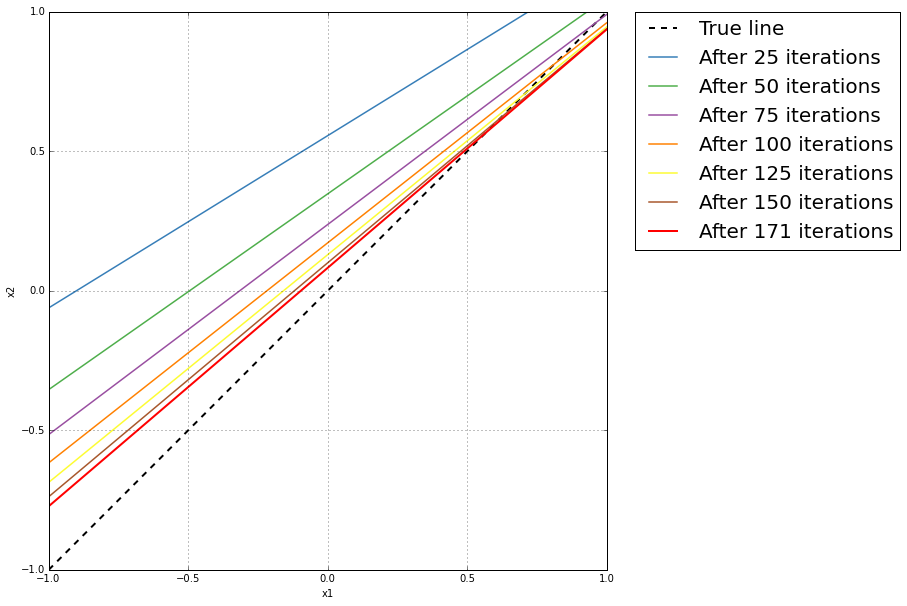

In [17]:
test = sc.textFile('testing_set.csv').map(readPoint_W).cache()

np.random.seed(12345)

Error_Vector_LR3 = logRegressionGDReg(train, test, 
                                      iterations=200, regParam=0.01, 
                                      regType="Lasso")

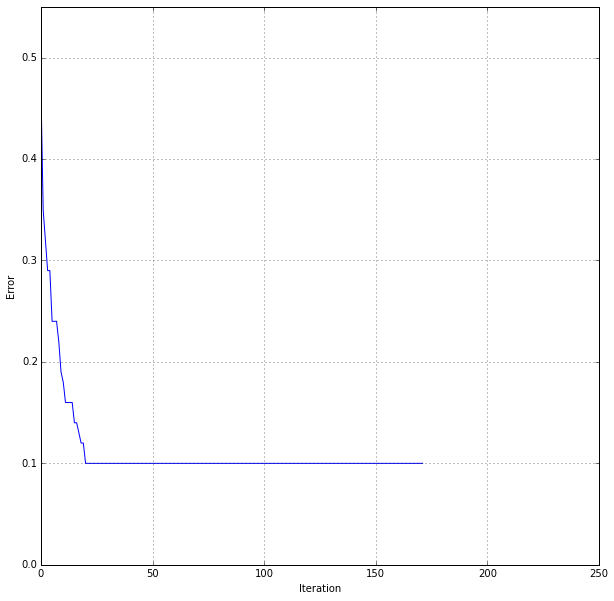

In [18]:
num_iter = len(Error_Vector_LR3)
plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_LR3)
plt.xlabel("Iteration")
plt.ylabel("Error")
axes = plt.gca()
axes.set_ylim(0,0.55)
axes.set_xlim(0,250)
plt.grid()
plt.show()

The convergence criterion is again met at the 171st iteration (the initial weights are random, but we've used the same seed), and the minimum misclassification error (even in the testing set) is reached at the 20th iteration (21st in the training set).

**Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set.**

I haven't found it, but it's just a matter of adapting the driver code a bit.

Iteration: 0
(weights=[0.0,0.0], intercept=1.0)
Testing Error: 0.5
------------------
Iteration: 1
(weights=[-0.948945011569,0.858685898015], intercept=0.57851118080178)
Testing Error: 0.1
------------------
Iteration: 2
(weights=[-1.49020010012,1.30541316645], intercept=0.22115047781724922)
Testing Error: 0.1
------------------
Iteration: 3
(weights=[-1.68832223728,1.40713499495], intercept=0.059152696195016896)
Testing Error: 0.1
------------------
Iteration: 4
(weights=[-1.82319446812,1.40282175328], intercept=-0.061799745117203445)
Testing Error: 0.1
------------------
Iteration: 5
(weights=[-1.83546710002,1.39346038202], intercept=-0.010781672085279512)
Testing Error: 0.1
------------------
Iteration: 6
(weights=[-1.85751750352,1.37856906133], intercept=0.01656048933220277)
Testing Error: 0.1
------------------
Iteration: 7
(weights=[-1.88997466996,1.36303912521], intercept=0.00703260090228678)
Testing Error: 0.1
------------------
Iteration: 8
(weights=[-1.98511759644,1.298438252

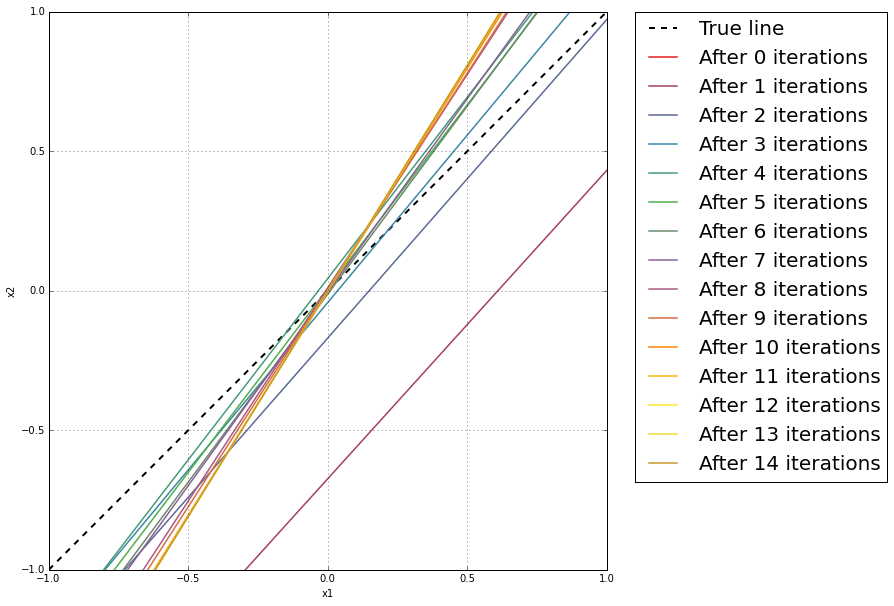

In [19]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, \
    LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
import itertools

iterations = 20
## Define equally spaced colors for each iteration
colors = plt.cm.Set1(np.linspace(0, 1, iterations+1))

def parsePoint_W(line):
    ## Change labels to 0 and 1 (rather than -1 and 1)
        ## Those are the values accepted by MLLib
    values = [float(x) for x in line.split(',')]
    x = list(values[:2]/np.sqrt(np.sum(np.array(values[:2])**2)))
    if values[2] == -1:
        y = 0
    elif values[2] == 1:
        y = 1
    return LabeledPoint(y, x)

## Load and cache both sets
training = sc.textFile("training_set.csv")
testing = sc.textFile("testing_set.csv")
training = training.map(parsePoint_W).cache()
testing = testing.map(parsePoint_W).cache()

## Draw the true hyperplane
x1 = [-1, 1]
w = [-1, 1, 0]
x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
plt.figure(figsize=(10,10))
plt.plot(x1, x2, 'b', label="True line", linewidth=2.0, color = 'black', 
         linestyle='--')

prev_w = [float('inf')]*3
#prev_Err = float('inf')

## Try a few iterations (no need for more in this case)
for it in range(iterations+1):
    print 'Iteration: {}'.format(it)
    # Build the model (Lasso/L1, lambda = 0.5)
    model = LogisticRegressionWithLBFGS.train(training, regType="l1", 
                                              regParam=0.01, 
                                              intercept = True, 
                                              iterations = it)
    print model

    # Evaluating the model on testing data
    labelsAndPreds = testing.\
        map(lambda p: (p.label, model.predict(p.features)))
    Err = labelsAndPreds.\
        filter(lambda (v, p): v != p).count() / float(testing.count())
    w = [model.weights[0], model.weights[1], model.intercept]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    ## Plot the hyperplanes
    plt.plot(x1, x2, color=colors[it], label="After {} iterations".
             format(str(it)), linewidth=1.5)
    
    ## Stop when it converges
    comb = [c for c in itertools.combinations(range(len(w)),2)]
    ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) 
                               for (i,j) in comb])
    condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
    if condition.all(axis=0):
        break
    
    prev_w = w
    #prev_Err = Err
    print "Testing Error: {}".format(str(Err))
    print '------------------'

## Last iteration's results
print "Testing Error: {}".format(str(Err))
print '------------------'
print 'CONVERGENCE AFTER {} ITERATIONS'.format(it)
print 'Relative change of weights (incl. intercept) between iterations '\
    '{} and {}:\n\t{}'.format(it-1, it, [a/b for (a,b) in zip(w,prev_w)])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
plt.grid()
plt.show()

Now it takes a few more iterations to converge (14 vs. 9, still less than with the homegrown code), but the minimum misclassification error in the testing set is achieved even with just 1 iteration.

# HW11.4: SVMs

**Use the non-linearly separable training and testing datasets from HW11.3 in this problem.**

## HW11.4.1
**Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words.**

The criterion for convergence is the same as before. All the code is pretty much the same, we just have to use `SVMWithSGD` instead of `LogisticRegressionWithLBFGS`.

This time I've chosen L2 regularization, the default for linear SVMs.

Iteration: 0
(weights=[0.0,0.0], intercept=1.0)
Testing Error: 0.5
------------------
Iteration: 1
(weights=[-0.189765064992,0.19328077111], intercept=0.49)
Testing Error: 0.5
------------------
Iteration: 2
(weights=[-0.470588018506,0.482956054954], intercept=0.4865351767721859)
Testing Error: 0.31
------------------
Iteration: 3
(weights=[-0.605507124377,0.633900753184], intercept=0.35670910539767176)
Testing Error: 0.22
------------------
Iteration: 4
(weights=[-0.715648172666,0.748921153708], intercept=0.2249255598706834)
Testing Error: 0.18
------------------
Iteration: 5
(weights=[-0.798787569618,0.842295806814], intercept=0.1344769430871957)
Testing Error: 0.11
------------------
Iteration: 6
(weights=[-0.857119730682,0.909025704132], intercept=0.06860821679175609)
Testing Error: 0.1
------------------
Iteration: 7
(weights=[-0.902379203429,0.95962474485], intercept=0.022993165345610835)
Testing Error: 0.1
------------------
Iteration: 8
(weights=[-0.9379015849,0.993555337252], 

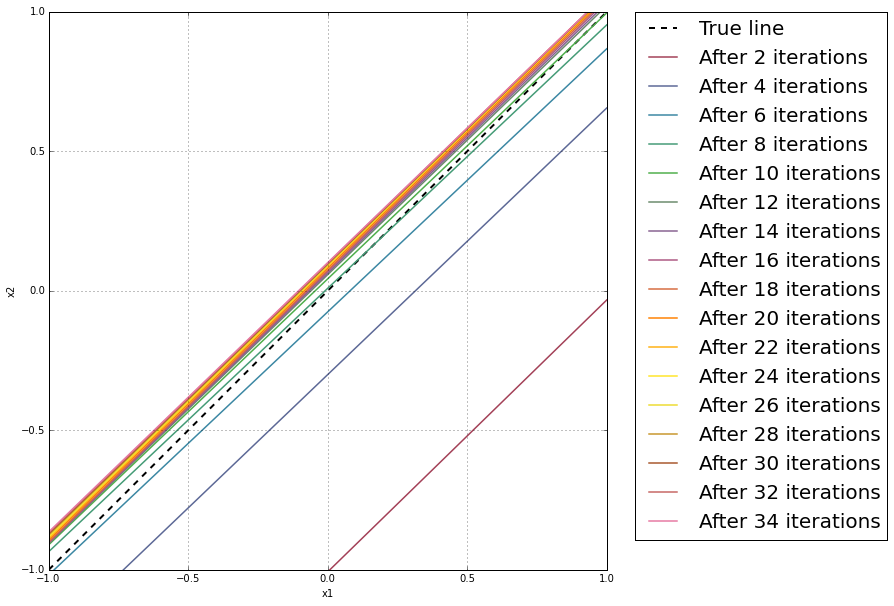

In [20]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

iterations = 40
## Define equally spaced colors for each iteration
colors = plt.cm.Set1(np.linspace(0, 1, iterations/2+1))

def parsePoint(line):
    ## Change labels to 0 and 1 (rather than -1 and 1)
        ## Those are the values accepted by MLLib
    values = [float(x) for x in line.split(',')]
    if values[2] == -1:
        y = 0
    elif values[2] == 1:
        y = 1
    return LabeledPoint(y, values[:2])

## Load and cache both sets
training = sc.textFile("training_set.csv")
testing = sc.textFile("testing_set.csv")
training = training.map(parsePoint).cache()
testing = testing.map(parsePoint).cache()

## Draw the true hyperplane
x1 = [-1, 1]
w = [-1, 1, 0]
x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
plt.figure(figsize=(10,10))
plt.plot(x1, x2, 'b', label="True line", linewidth=2.0, color = 'black', 
         linestyle='--')

prev_w = [float('inf')]*3
#prev_Err = float('inf')

## Try a few iterations (no need for more in this case)
for it in range(iterations+1):
    print 'Iteration: {}'.format(it)
    # Build the model (Lasso/L1, lambda = 0.5)
    model = SVMWithSGD.train(training, regType="l2", regParam=0.01, 
                             intercept = True, iterations = it)
    print model

    # Evaluating the model on testing data
    labelsAndPreds = testing.\
        map(lambda p: (p.label, model.predict(p.features)))
    Err = labelsAndPreds.\
        filter(lambda (v, p): v != p).count() / float(testing.count())
    w = [model.weights[0], model.weights[1], model.intercept]
    if it % 2 == 0 and it != 0:
        x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
        ## Plot the hyperplanes
        plt.plot(x1, x2, color=colors[it/2], label="After {} iterations".
                 format(str(it)), linewidth=1.5)
    
    comb = [c for c in itertools.combinations(range(len(w)),2)]
    ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) 
                               for (i,j) in comb])
    condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
    if condition.all(axis=0):
        break
    
    prev_w = w
    #prev_Err = Err
    print "Testing Error: {}".format(str(Err))
    print '------------------'

## Last iteration's results
print "Testing Error: {}".format(str(Err))
print '------------------'
print 'CONVERGENCE AFTER {} ITERATIONS'.format(it)
print 'Relative change of weights (incl. intercept) between iterations '\
    '{} and {}:\n\t{}'.format(it-1, it, [a/b for (a,b) in zip(w,prev_w)])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
plt.grid()
plt.show()

It takes more iterations to converge than with the MLLib version of Logistic Regression: the minimum error is achieved at the 6th iteration, and the converge criterion is met at the 35th iteration.

## HW11.4.2
**Derive and Implement in Spark a weighted soft linear svm classification learning algorithm.**

Again, I define a general-purpose function that works with weighted or unweighted data, uses the convergence criterion describe previously, and so on. The main changes apply of course to the loss function, the gradient, and the predictions.

In [21]:
def SVM_GDReg(training, testing, wInitial=None, 
                         learningRate=0.05, iterations=50, regParam=0.1):
        
    ## Draw the true hyperplane
    x1 = [-1, 1]
    w = [-1, 1, 0]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.figure(figsize=(10,10))
    plt.plot(x1, x2, 'b', label="True line", linewidth=2.0, color = 'black', 
             linestyle='--')

    featureLen = len(training.take(1)[0].x)
    n = training.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    else:
        w = wInitial
    prev_w = np.array([float('inf')]*featureLen)
    #prev_Err = float('inf')
    Err_vector = []
    Num_SVs = []
    convergence = False
    
    x1 = [-1,1]
    colors = plt.cm.Set1(np.linspace(0, 1, iterations/10+1))
    
    for it in range(iterations+1):
        wBroadcast = sc.broadcast(w)
        sv = training.\
            filter(lambda p: p.y * np.dot(wBroadcast.value, p.x) < 1)
            ## Only support vectors (label*margin) < 1
        if sv.isEmpty(): ## Converged as no more updates possible
            print 'No more support vectors at iteration {}'.\
                format(str(it))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, 
                       borderaxespad=0.)
            plt.xlabel("x1")
            plt.ylabel("x2")
            axes = plt.gca()
            axes.set_xlim([-1,1])
            axes.set_ylim([-1,1])
            plt.grid()
            plt.show()
            break ## Hinge loss component of gradient y*x and sum up 
        gradient = sv.map(lambda p: -p.y * np.array(p.x)).\
            reduce(lambda a,b: a + b) / n ## Gradient = average hinge loss
        num_sv = sv.count()
        
        ## PREDICTIONS: sign(w^T*x)
        errors = testing.\
            map(lambda p: p.y != np.sign(np.dot(wBroadcast.value, p.x))).\
            filter(lambda pred: pred == True).count()
        Err = float(errors) / n
        Err_vector.append(Err)
        Num_SVs.append(num_sv)
        
        if Err == 0.1 and convergence == False:
            print '+++++++++++++++++++++++++++++++++++++++'
            print 'Minimum error achieved at iteration {}'.format(it)
            print 'Ratio of weights at this iteration:'
            print '\t{}'.format(ratio_of_ratio)
            print '+++++++++++++++++++++++++++++++++++++++'
            convergence = True

        wReg = w*1 ## wReg = w in Ridge/L2
        wReg[-1] = 0
        ## Gradient: hinge loss + regularized term 
        wDelta = learningRate*(gradient + regParam*wReg)

        if it % 25 == 0 and it != 0:
            print 'Iteration {}'.format(str(it))
            print '\tSupport vectors:\t{}'.format(str(num_sv))
            print '\tWeights:\t\t{}'.format(w)
            print '\tError rate:\t\t{}'.format(str(Err))
            print '----------------------------'
            x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
            ## Plot the hyperplanes
            plt.plot(x1, x2, color=colors[it/25], label="After {} iterations".
                 format(str(it)), linewidth=1.5)        
        
        comb = [c for c in itertools.combinations(range(len(w)),2)]
        ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) 
                                   for (i,j) in comb])
        condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
        if condition.all(axis=0):
            if Err != 0.1 and convergence == False:
                print '+++++++++++++++++++++++++++++++++++++++++++'
                print 'Converge criterion met after {} iterations'\
                    'but lowest error not achieved yet.'.format(str(it))
                print '+++++++++++++++++++++++++++++++++++++++++++'
                convergence = True
            else:
                print 'Converged after {} iterations.'.format(str(it))
                print '\tSupport vectors:\t{}'.format(str(num_sv))
                print '\tWeights:\t\t{}'.format(w)
                print '\tError rate:\t\t{}'.format(str(Err))
                x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
                plt.plot(x1, x2, color='red', label="After {} iterations".
                         format(str(it)), linewidth=2.0)
                plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, 
                           borderaxespad=0.)
                plt.xlabel("x1")
                plt.ylabel("x2")
                axes = plt.gca()
                axes.set_xlim([-1,1])
                axes.set_ylim([-1,1])
                plt.grid()
                plt.show()
                break
        prev_w = w
        w = w - wDelta
        
    return (Num_SVs, Err_vector)

Let's see the results using the unweighted data and checking the error in the training set.

Iteration 25
	Support vectors:	80
	Weights:		[-0.56498189  0.80704476 -0.29993872]
	Error rate:		0.12
----------------------------
+++++++++++++++++++++++++++++++++++++++
Minimum error achieved at iteration 49
Ratio of weights at this iteration:
	[ 1.00217018  1.03877984  1.03653038]
+++++++++++++++++++++++++++++++++++++++
Iteration 50
	Support vectors:	58
	Weights:		[-0.8201958   1.03681115 -0.12543872]
	Error rate:		0.1
----------------------------
Converged after 66 iterations.
	Support vectors:	50
	Weights:		[-0.90047416  1.10790037 -0.10343872]
	Error rate:		0.1


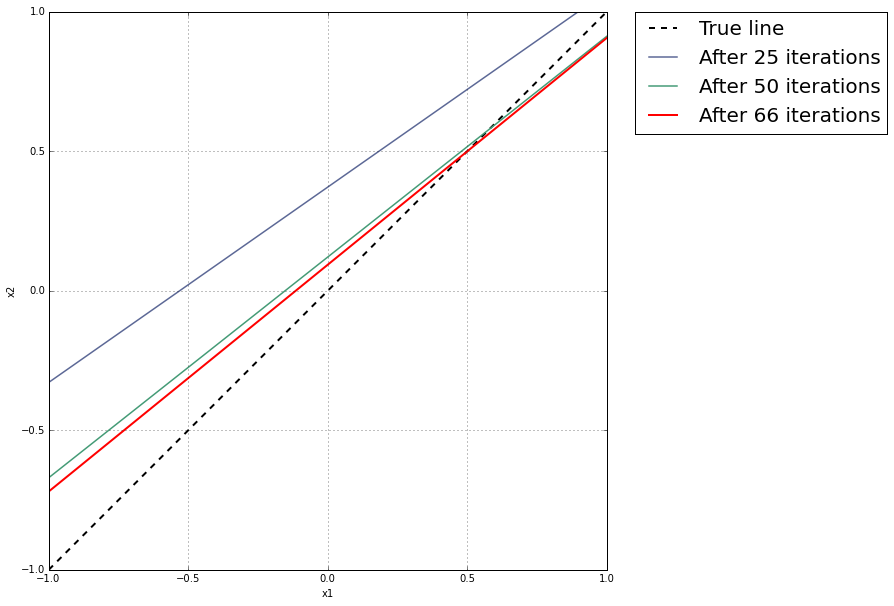

In [22]:
train = sc.textFile('training_set.csv').map(readPoint).cache()

np.random.seed(12345)
Error_Vector_SVM1 = SVM_GDReg(train, train, learningRate = 0.05, 
                              iterations=100, regParam=0.01)

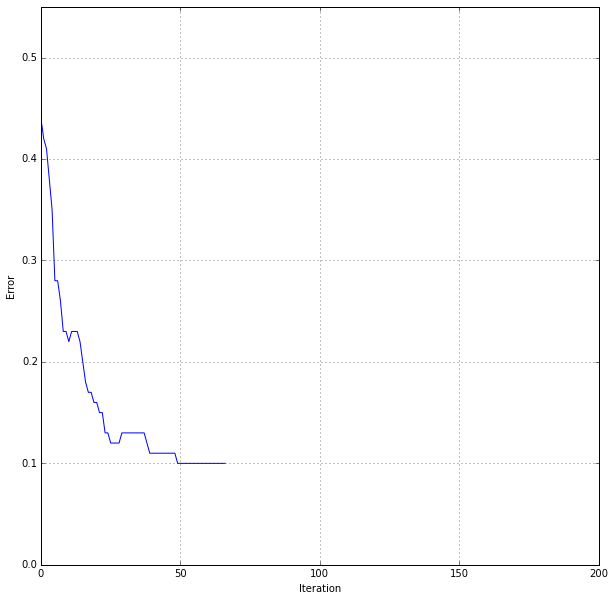

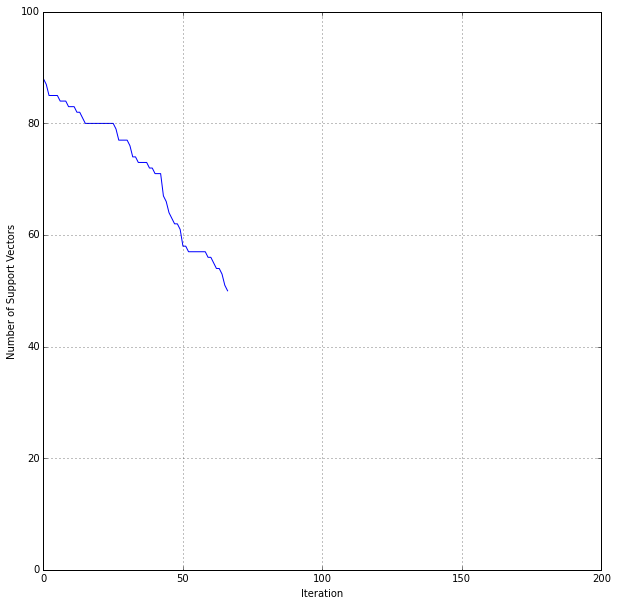

In [23]:
num_iter = len(Error_Vector_SVM1[0])

plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_SVM1[1])
plt.xlabel("Iteration")
plt.ylabel("Error")
axes = plt.gca()
axes.set_ylim(0,0.55)
axes.set_xlim(0,200)
plt.grid()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_SVM1[0])
plt.xlabel("Iteration")
plt.ylabel("Number of Support Vectors")
axes = plt.gca()
axes.set_ylim(0, 100)
axes.set_xlim(0, 200)
plt.grid()
plt.show()

Unlike the MLLib version, which took more iterations to converge (compared to Logistic Regression), the homegrown code takes less: 49 to get the minimum misclassification error, and 66 to meet the convergence criterion that I defined. We end up with 50 support vectors (of the possible 100, though the 10 mislabeled points should not be support vectors at convergence).

Let's see what happens when weights are applied (again, using the `readPoint_W` function and applying the weighted data to the ML function):

+++++++++++++++++++++++++++++++++++++++
Minimum error achieved at iteration 9
Ratio of weights at this iteration:
	[ 1.02780746  1.09316961  1.06359377]
+++++++++++++++++++++++++++++++++++++++
Iteration 25
	Support vectors:	67
	Weights:		[-0.62235832  0.81621781 -0.11843872]
	Error rate:		0.1
----------------------------
Iteration 50
	Support vectors:	25
	Weights:		[-0.76351507  0.90790916 -0.01243872]
	Error rate:		0.1
----------------------------
Converged after 53 iterations.
	Support vectors:	25
	Weights:		[-0.7681997   0.90710017 -0.01143872]
	Error rate:		0.1


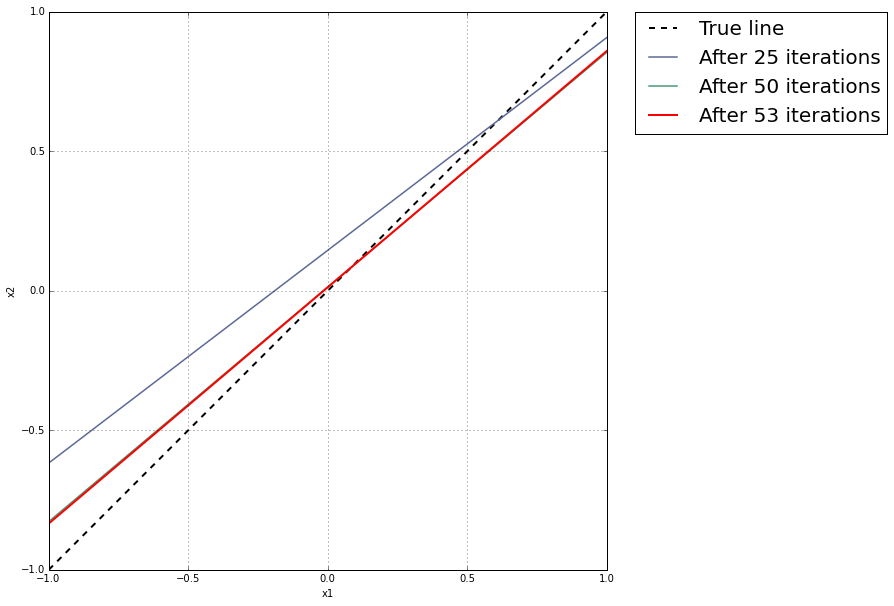

In [24]:
train = sc.textFile('training_set.csv').map(readPoint_W).cache()

np.random.seed(12345)
Error_Vector_SVM2 = SVM_GDReg(train, train, learningRate = 0.05, 
                              iterations=100, regParam=0.01)

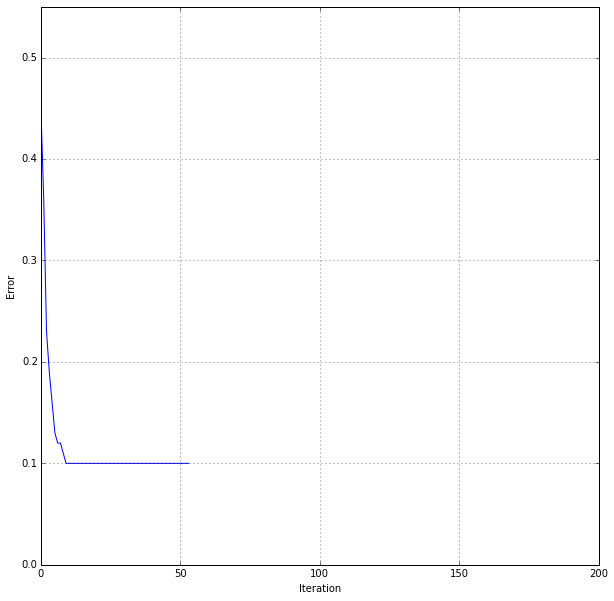

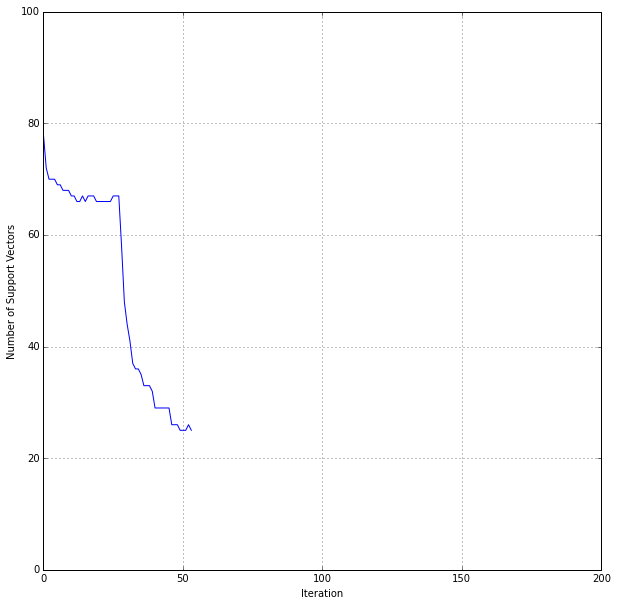

In [25]:
num_iter = len(Error_Vector_SVM2[0])

plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_SVM2[1])
plt.xlabel("Iteration")
plt.ylabel("Error")
axes = plt.gca()
axes.set_ylim(0,0.55)
axes.set_xlim(0,200)

plt.grid()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_SVM2[0])
plt.xlabel("Iteration")
plt.ylabel("Number of Support Vectors")
axes = plt.gca()
axes.set_ylim(0, 100)
axes.set_xlim(0, 200)
plt.grid()
plt.show()

Now the SVM converges even faster: after 9 iterations we have an error (in the training set) of 10%, and with 53 we've met the convergence criterion.

The number of support vectors with weighted data is reduced to 25.

## HW11.4.3
**Evaluate your homegrown weighted soft linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up?**

+++++++++++++++++++++++++++++++++++++++
Minimum error achieved at iteration 9
Ratio of weights at this iteration:
	[ 1.02780746  1.09316961  1.06359377]
+++++++++++++++++++++++++++++++++++++++
Iteration 25
	Support vectors:	67
	Weights:		[-0.62235832  0.81621781 -0.11843872]
	Error rate:		0.1
----------------------------
Iteration 50
	Support vectors:	25
	Weights:		[-0.76351507  0.90790916 -0.01243872]
	Error rate:		0.1
----------------------------
Converged after 53 iterations.
	Support vectors:	25
	Weights:		[-0.7681997   0.90710017 -0.01143872]
	Error rate:		0.1


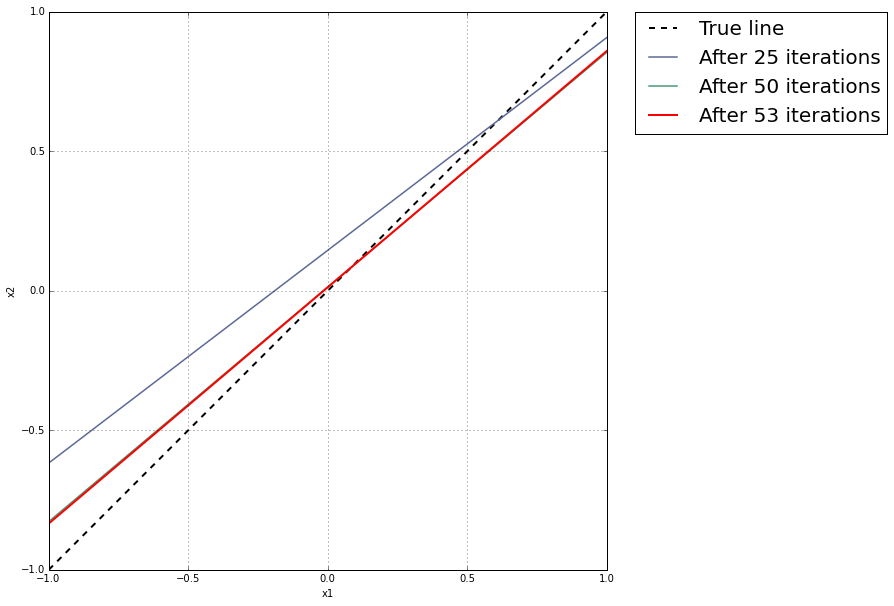

In [26]:
test = sc.textFile('testing_set.csv').map(readPoint_W).cache()

np.random.seed(12345)
Error_Vector_SVM3 = SVM_GDReg(train, test, learningRate = 0.05, 
                              iterations=100, regParam=0.01)

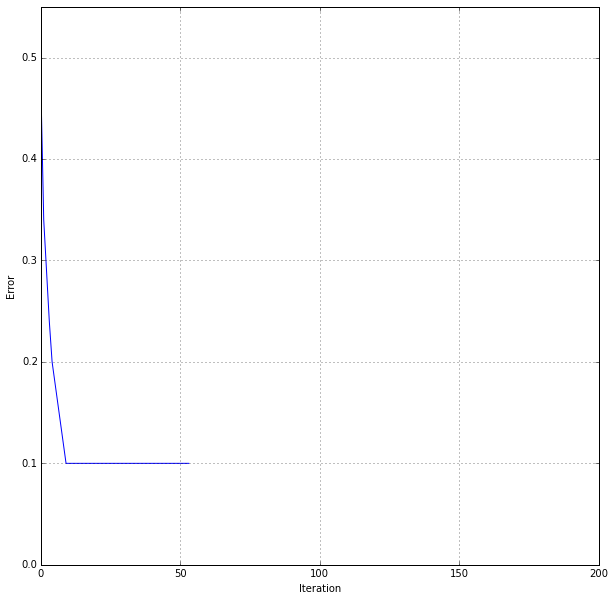

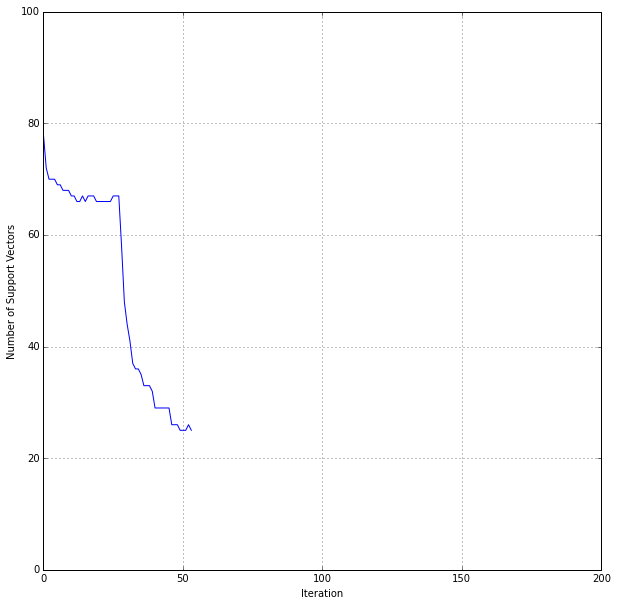

In [27]:
num_iter = len(Error_Vector_SVM3[0])

plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_SVM3[1])
plt.xlabel("Iteration")
plt.ylabel("Error")
axes = plt.gca()
axes.set_ylim(0,0.55)
axes.set_xlim(0,200)
plt.grid()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(range(num_iter), Error_Vector_SVM3[0])
plt.xlabel("Iteration")
plt.ylabel("Number of Support Vectors")
axes = plt.gca()
axes.set_ylim(0, 100)
axes.set_xlim(0, 200)
plt.grid()
plt.show()

Even with the test set after 9 iterations (again) we get the lowest error possible: 10%. As mentioned in HW11.3, the iterations to meet the convergence criterion are the same than before because I used the same seed to generate the initial weights.

Again (this depends on the convergence criterion, not on the training or testing error) we end up with only 25 support vectors.

## HW11.4.4
**Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.**

Again, it doesn't seem so (http://apache-spark-user-list.1001560.n3.nabble.com/MLlib-weighted-training-td10291.html) but we can adapt the previous code.

Iteration: 0
(weights=[0.0,0.0], intercept=1.0)
Testing Error: 0.5
------------------
Iteration: 1
(weights=[-0.260571734573,0.260689310044], intercept=0.49)
Testing Error: 0.5
------------------
Iteration: 2
(weights=[-0.621161180236,0.631776138619], intercept=0.4865351767721859)
Testing Error: 0.1
------------------
Iteration: 3
(weights=[-0.753607400164,0.75530032649], intercept=0.22391854348405782)
Testing Error: 0.1
------------------
Iteration: 4
(weights=[-0.867846361418,0.871655742856], intercept=0.00779895076663753)
Testing Error: 0.1
------------------
Iteration: 5
(weights=[-0.865681126364,0.876469703429], intercept=-0.0011801991114963805)
Testing Error: 0.1
------------------
Iteration: 6
(weights=[-0.864333338295,0.884879711549], intercept=-0.005257863873438257)
Testing Error: 0.1
------------------
Iteration: 7
(weights=[-0.854530618118,0.883927574372], intercept=-0.0014583462858652019)
Testing Error: 0.1
------------------
Iteration: 8
(weights=[-0.852337538101,0.8841941

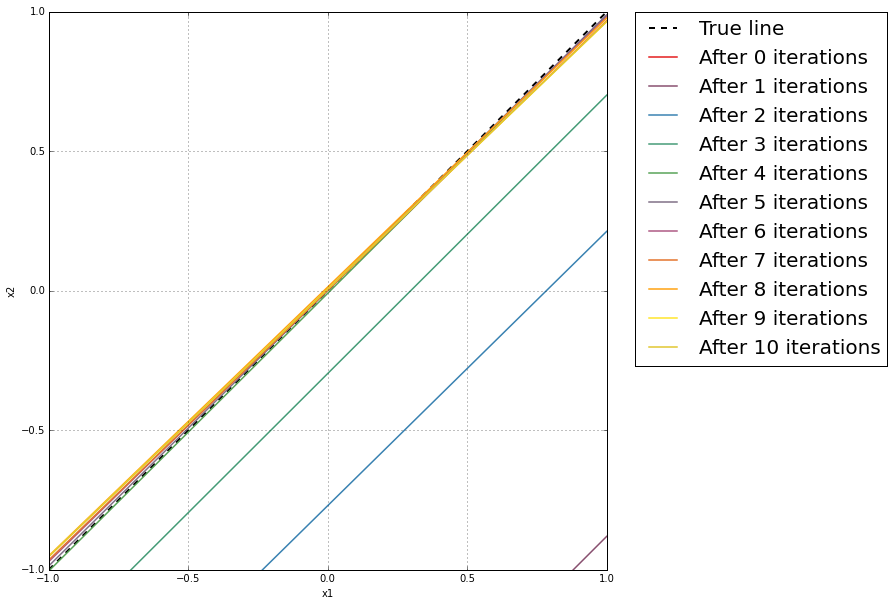

In [28]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
import itertools

iterations = 15
## Define equally spaced colors for each iteration
colors = plt.cm.Set1(np.linspace(0, 1, iterations+1))

def parsePoint_W(line):
    ## Change labels to 0 and 1 (rather than -1 and 1)
        ## Those are the values accepted by MLLib
    values = [float(x) for x in line.split(',')]
    x = list(values[:2]/np.sqrt(np.sum(np.array(values[:2])**2)))
    if values[2] == -1:
        y = 0
    elif values[2] == 1:
        y = 1
    return LabeledPoint(y, x)

## Load and cache both sets
training = sc.textFile("training_set.csv")
testing = sc.textFile("testing_set.csv")
training = training.map(parsePoint_W).cache()
testing = testing.map(parsePoint_W).cache()

## Draw the true hyperplane
x1 = [-1, 1]
w = [-1, 1, 0]
x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
plt.figure(figsize=(10,10))
plt.plot(x1, x2, 'b', label="True line", linewidth=2.0, color = 'black', 
         linestyle='--')

prev_w = [float('inf')]*3
#prev_Err = float('inf')

## Try a few iterations (no need for more in this case)
for it in range(iterations+1):
    print 'Iteration: {}'.format(it)
    # Build the model (Lasso/L1, lambda = 0.5)
    model = SVMWithSGD.train(training, regType="l2", regParam=0.01, 
                             intercept = True, iterations = it)
    print model

    # Evaluating the model on testing data
    labelsAndPreds = testing.\
        map(lambda p: (p.label, model.predict(p.features)))
    Err = labelsAndPreds.\
        filter(lambda (v, p): v != p).count() / float(testing.count())
    w = [model.weights[0], model.weights[1], model.intercept]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    ## Plot the hyperplanes
    plt.plot(x1, x2, color=colors[it], label="After {} iterations".
             format(str(it)), linewidth=1.5)
    
    comb = [c for c in itertools.combinations(range(len(w)),2)]
    ratio_of_ratio = np.array([(w[i]/prev_w[i])/(w[j]/prev_w[j]) 
                               for (i,j) in comb])
    condition = (0.99<=ratio_of_ratio) & (ratio_of_ratio<=1.01)
    if condition.all(axis=0):
        break
    
    prev_w = w
    #prev_Err = Err
    print "Testing Error: {}".format(str(Err))
    print '------------------'

## Last iteration's results
print "Testing Error: {}".format(str(Err))
print '------------------'
print 'CONVERGENCE AFTER {} ITERATIONS'.format(it)
print 'Relative change of weights (incl. intercept) between iterations '\
    '{} and {}:\n\t{}'.format(it-1, it, [a/b for (a,b) in zip(w,prev_w)])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
plt.grid()
plt.show()

# SUMMARY

|LR|MLLib|homegrown|hw weighted|hw weighted w/ test|MLLib weighted|
|:---:|:---:|:---:|:---:|:---:|:---:|
|Iterations until Min. Error|2|140|21|20|1|
|Iterations until Conv. crit.|10|136|171|171|14|

|SVM|MLLib|homegrown|hw weighted|hw weighted w/ test|MLLib weighted|
|:---:|:---:|:---:|:---:|:---:|:---:|
|Iterations until Min. Error|6|49|9|9|2|
|Iterations until Conv. crit.|35|66|53|53|10|
|Support Vectors|-|50|25|25|-|